<a href="https://colab.research.google.com/github/VCHULANI15/VCHULANI15/blob/main/Portfolio_Allocation_x_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np

file_path = '/content/drive/My Drive/PortfolioOptimization/StockDataa_2024-03-25.csv'
df = pd.read_csv(file_path)

print(df.head())


         Date Index       Open       High        Low      Close       Volume  \
0  2014-03-28  AMZN  17.002501  17.350000  16.804001  16.914499   79736000.0   
1  2014-03-31  AMZN  17.120001  17.314501  16.702999  16.818501   85950000.0   
2  2014-04-01  AMZN  16.904499  17.221500  16.900000  17.149500   72002000.0   
3  2014-04-02  AMZN  17.299500  17.415001  17.018999  17.098000   89510000.0   
4  2014-04-03  AMZN  17.091000  17.125000  16.423000  16.681000  127986000.0   

    Adjusted  
0  16.914499  
1  16.818501  
2  17.149500  
3  17.098000  
4  16.681000  


In [8]:
df['Date']= pd.to_datetime(df['Date'])
df_close = df[['Date', 'Index', 'Close']]
df_close = df_close.pivot_table(index = 'Date', columns = 'Index', values='Close').dropna(axis=1)
#Log Returns
df_returns = (df_close.apply(lambda x: np.log(x) - np.log(x.shift(1)))).iloc[1:]

In [9]:
def dailyMovingAverage(df_close, moving_avg_period):
  dates = df_close.index[moving_avg_period:] #Storing dates of the required dates
  stocks = df_close.columns #Storing stock names
  moving_avg = []

  for i in range(df_close.shape[0]-moving_avg_period):
    mean = df_close.iloc[i:i+moving_avg_period,:].mean()
    moving_avg.append(mean)

  return pd.DataFrame(data = moving_avg, index = dates, columns = stocks)

In [10]:
movingAverage = dailyMovingAverage(df_close, 252)

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
assets = ['TSLA', 'AMZN', 'BTC-USD']
data = yf.download(assets, start='2020-01-01', end='2024-03-14')['Adj Close']

[*********************100%%**********************]  3 of 3 completed


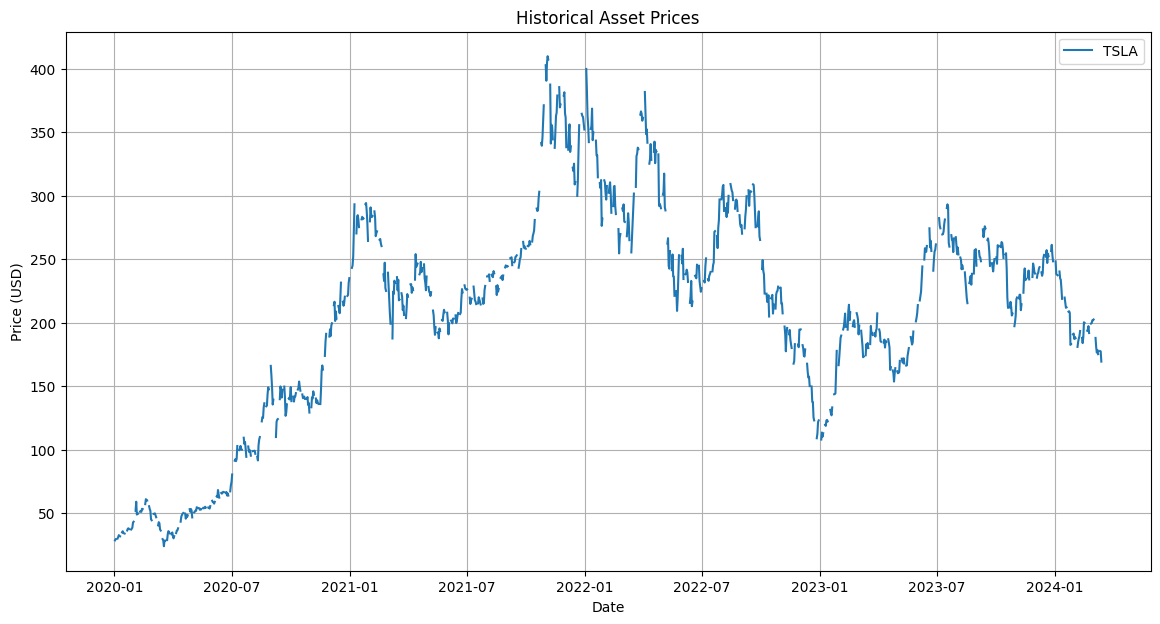

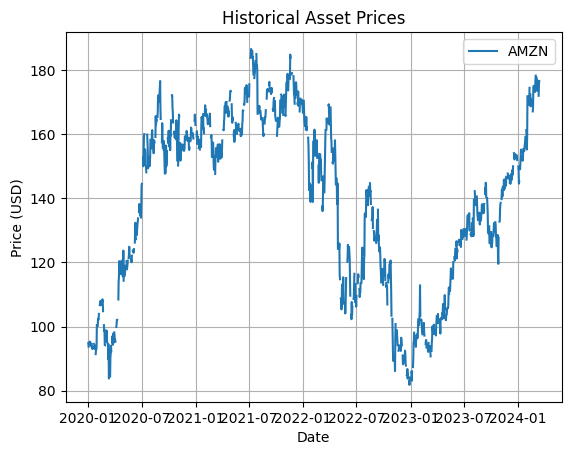

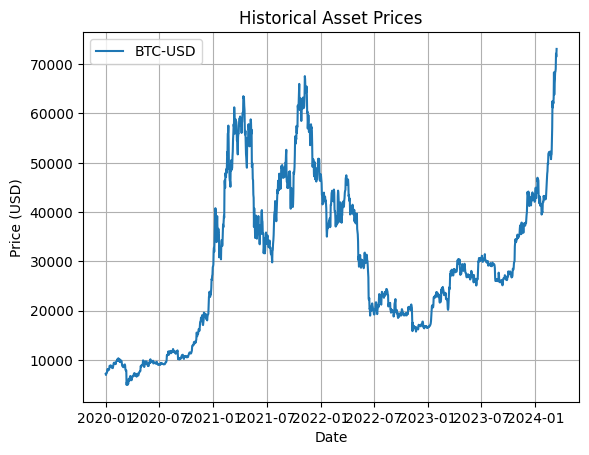

In [ ]:
plt.figure(figsize=(14, 7))
for asset in assets:
  plt.plot(data.index, data[asset], label=asset)
  plt.title('Historical Asset Prices')
  plt.xlabel('Date')
  plt.ylabel('Price (USD)')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
# Annualized returns and covariance matrix
annual_returns = mean_returns * 252
annual_covariance = cov_matrix * 252

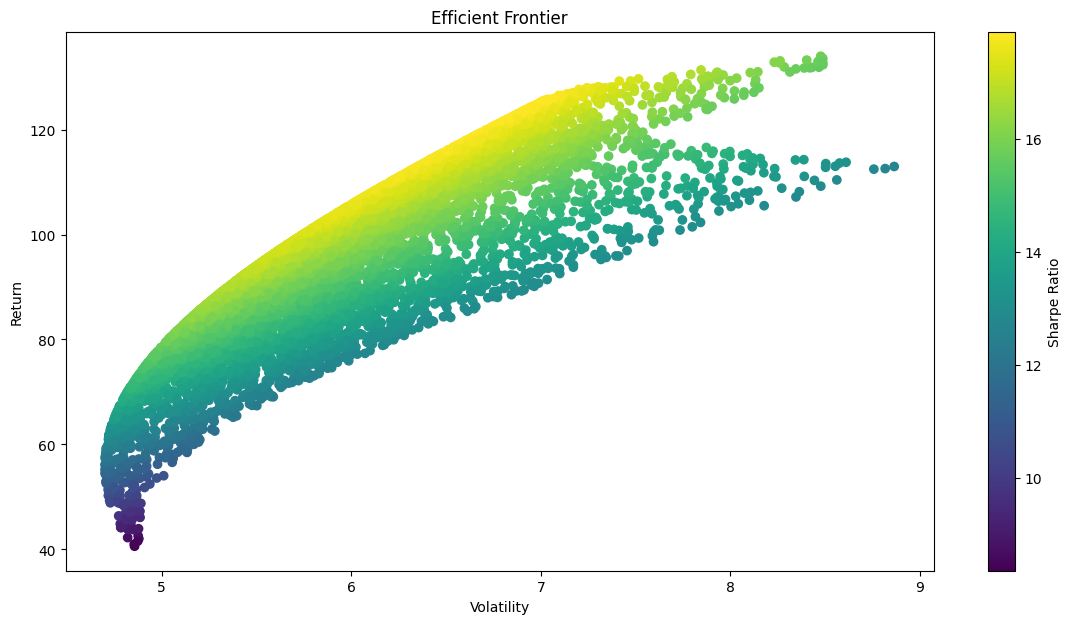

In [ ]:
class Portfolio:
  def __init__(self, returns, cov_matrix):
    self.returns = returns
    self.cov_matrix = cov_matrix

  def generate_random_portfolios(self, num_portfolios):
    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
      weights = np.random.random(3)
      weights /= np.sum(weights)
      weights_record.append(weights)
      portfolio_return = np.sum(self.returns * weights) * 252
      portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights))) * np.sqrt(252)
      results[0, i] = portfolio_return
      results[1, i] = portfolio_std_dev
      results[2, i] = portfolio_return / portfolio_std_dev
    return results, weights_record
portfolio = Portfolio(annual_returns, annual_covariance)
num_portfolios = 10000
results, weights = portfolio.generate_random_portfolios(num_portfolios)

plt.figure(figsize=(14, 7))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()


In [ ]:
class RebalancingStrategy:
  def __init__(self, assets, returns, cov_matrix):
    self.assets = assets
    self.returns = returns
    self.cov_matrix = cov_matrix
  def get_optimal_weights(self):
    portfolio = Portfolio(self.returns, self.cov_matrix)
    num_portfolios = 10000
    results, weights = portfolio.generate_random_portfolios(num_portfolios)
    max_sharpe_idx = np.argmax(results[2])
    optimal_weights = weights[max_sharpe_idx]
    return optimal_weights
  def rebalance_portfolio(self):
    optimal_weights = self.get_optimal_weights()
    current_prices = data.iloc[-1]
    portfolio_value = 1000000
    asset_values = {asset: portfolio_value * weight for asset, weight in zip(self.assets, optimal_weights)}
    shares_to_buy = {asset: asset_values[asset] / price for asset, price in current_prices.items()}
    return shares_to_buy
strategy = RebalancingStrategy(assets, annual_returns, annual_covariance)
shares_to_buy = strategy.rebalance_portfolio()
print(shares_to_buy)


{'AMZN': 3326.079265197136, 'BTC-USD': 5.541271308413398, 'TSLA': 45.85763266815499}
